2025-05-22 15:55:10,645 - INFO - Running comparison for awareness campaign on facebook with budget $1000


Starting model comparison...


2025-05-22 15:55:10,868 - INFO - [LP Model] Optimization completed in 0.22 seconds
2025-05-22 15:55:10,869 - INFO - [LP Model] Optimal duration: 32 days, Daily media cost: $31.25
2025-05-22 15:55:10,933 - INFO - [MINLP Model] Optimization completed in 0.06 seconds
2025-05-22 15:55:10,934 - INFO - [MINLP Model] Optimal duration: 22 days, Daily media cost: $45.45
2025-05-22 15:55:10,938 - INFO - Running comparison for awareness campaign on google with budget $1000
2025-05-22 15:55:10,994 - INFO - [LP Model] Optimization completed in 0.05 seconds
2025-05-22 15:55:10,995 - INFO - [LP Model] Optimal duration: 32 days, Daily media cost: $31.25
2025-05-22 15:55:11,047 - INFO - [MINLP Model] Optimization completed in 0.05 seconds
2025-05-22 15:55:11,048 - INFO - [MINLP Model] Optimal duration: 22 days, Daily media cost: $45.45
2025-05-22 15:55:11,049 - INFO - Running comparison for awareness campaign on dv360 with budget $1000
2025-05-22 15:55:11,102 - INFO - [LP Model] Optimization completed 


===== MODEL COMPARISON RESULTS =====

  Campaign Goal  Platform  LP Duration (days)  MINLP Duration (days)  \
0     Awareness  Facebook                  32                     22   
1     Awareness    Google                  32                     22   
2     Awareness     Dv360                  32                     22   
3    Conversion  Facebook                  52                     28   
4    Conversion    Google                  28                     28   
5    Conversion     Dv360                  34                     28   

   LP Daily Media Cost ($)  MINLP Daily Media Cost ($)  LP Impressions  \
0                    31.25                       45.45         73500.0   
1                    31.25                       45.45         70000.0   
2                    31.25                       45.45         66500.0   
3                    19.23                       35.71             NaN   
4                    35.71                       35.71             NaN   
5           

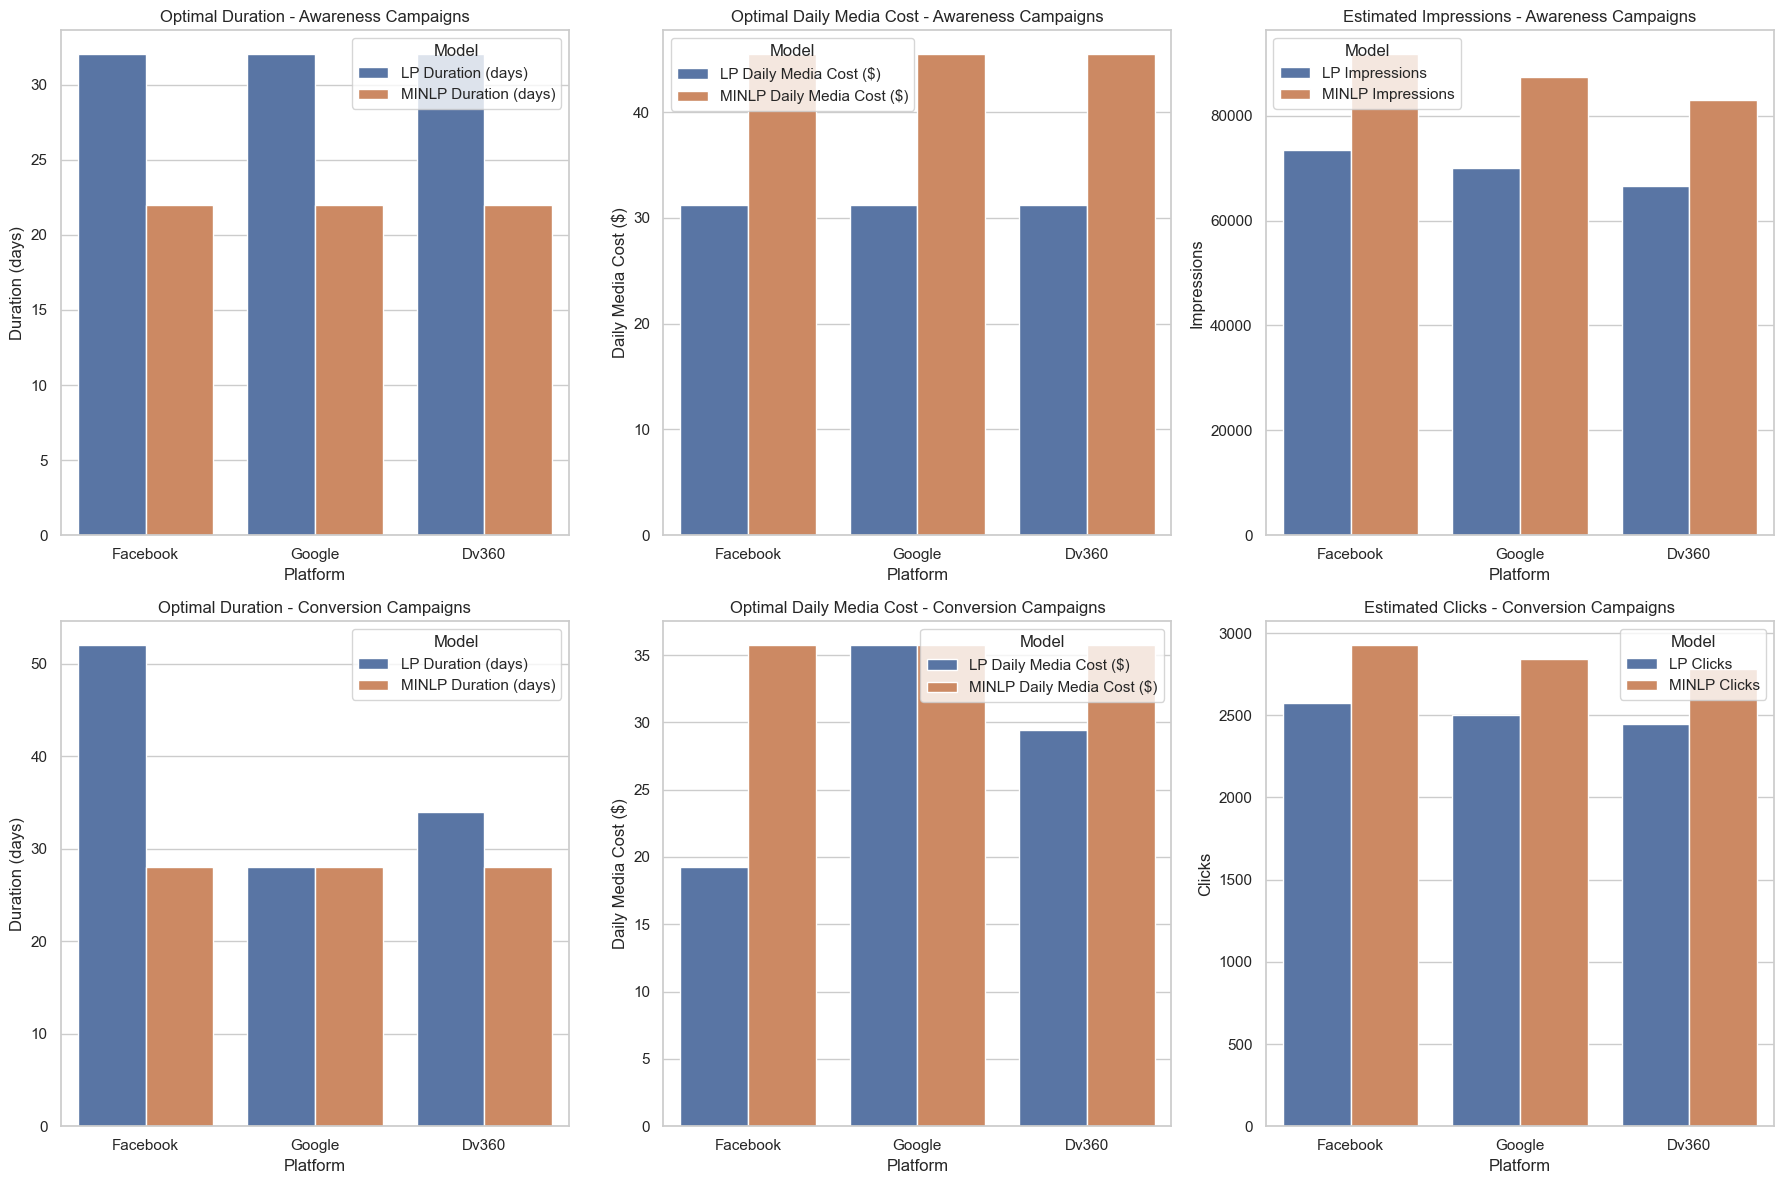

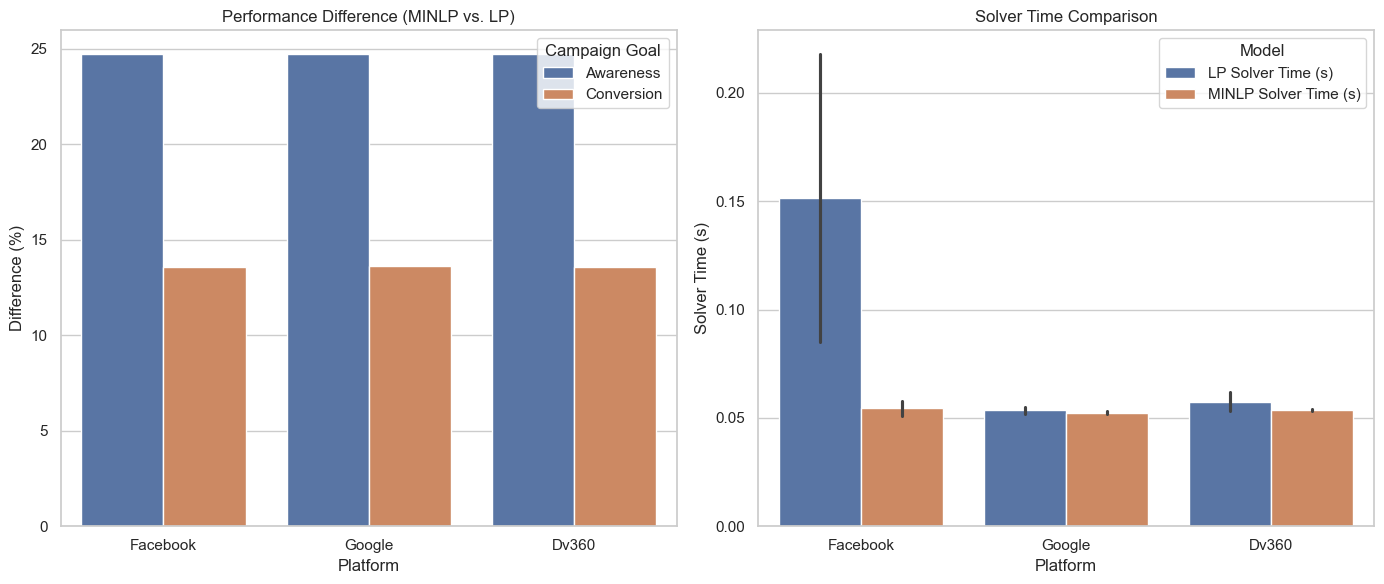

In [3]:
import os
import time
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Path to Bonmin solver
BONMIN_PATH = "path/to/bonmin.exe"

#################################################
# Linear Programming (LP) Benchmark Model
#################################################

def optimize_lp_model(campaign_goal, budget, platform, bonmin_path):
    """
    Implement a simple Linear Programming model as a benchmark
    """
    start_time = time.time()

    # Validate inputs
    if campaign_goal not in ['awareness', 'conversion']:
        raise ValueError("campaign_goal must be either 'awareness' or 'conversion'")

    if platform not in ['facebook', 'google', 'dv360']:
        raise ValueError("platform must be one of 'facebook', 'google', or 'dv360'")

    if budget <= 0:
        raise ValueError("budget must be greater than 0")

    # Define linear coefficients based on campaign goal
    if campaign_goal == 'awareness':
        # Linear approximation for impressions vs. media cost (using avg from polynomial)
        media_cost_linear = 70.0  # Average impressions per $1 of media cost
    else:
        # Linear approximation for clicks vs. media cost (using avg from polynomial)
        media_cost_linear = 2.5   # Average clicks per $1 of media cost

    # Platform performance coefficients
    platform_coefficients = {
        'facebook': {'impressions': 1.05, 'clicks': 1.03},
        'google': {'impressions': 1.00, 'clicks': 1.00},
        'dv360': {'impressions': 0.95, 'clicks': 0.98}
    }

    # Get the appropriate platform coefficient
    platform_coef = platform_coefficients[platform]['impressions'] if campaign_goal == 'awareness' else platform_coefficients[platform]['clicks']

    # Campaign constraints
    min_duration = 1
    max_duration = 103
    min_media_cost = 0.01

    # Create a concrete model
    model = pyo.ConcreteModel()

    # Decision variables
    model.duration = pyo.Var(domain=pyo.Integers, bounds=(min_duration, max_duration))
    model.media_cost = pyo.Var(domain=pyo.NonNegativeReals, bounds=(min_media_cost, None))

    # Budget constraint
    def budget_rule(model):
        return model.media_cost * model.duration <= budget
    model.budget_constraint = pyo.Constraint(rule=budget_rule)

    # Define function to calculate performance with linear relationship
    def calculate_linear_performance(model):
        # Linear media cost component
        media_cost_effect = media_cost_linear * model.media_cost

        # No diminishing returns - linear relationship with duration
        # Total effect: media_cost_effect * duration * platform_coef
        return media_cost_effect * model.duration * platform_coef

    # Objective function
    model.objective = pyo.Objective(rule=calculate_linear_performance, sense=pyo.maximize)

    # Create the solver
    solver = SolverFactory('bonmin', executable=bonmin_path)

    # Set solver options
    solver.options['bonmin.algorithm'] = 'B-BB'
    solver.options['bonmin.time_limit'] = 300

    # Solve the model
    try:
        results = solver.solve(model, tee=False)

        # Check solver status
        solver_status = results.solver.status
        termination_condition = results.solver.termination_condition

        if solver_status == SolverStatus.ok and termination_condition == TerminationCondition.optimal:
            # Extract solution
            duration_value = int(pyo.value(model.duration))
            media_cost_value = pyo.value(model.media_cost)
            total_cost = duration_value * media_cost_value

            # Calculate performance metrics
            solve_time = time.time() - start_time

            # Performance metrics
            metrics = {
                'solver_time': solve_time,
                'solver_status': str(solver_status),
                'termination_condition': str(termination_condition)
            }

            # Calculate the linear performance prediction
            linear_performance = media_cost_linear * media_cost_value * duration_value * platform_coef

            # Create results dictionary based on campaign goal
            if campaign_goal == 'awareness':
                optimization_results = {
                    'model_name': 'Linear',
                    'campaign_goal': campaign_goal,
                    'platform': platform,
                    'budget': budget,
                    'duration': duration_value,
                    'media_cost': media_cost_value,
                    'total_cost': total_cost,
                    'impressions': linear_performance,
                    'cpm': (total_cost / linear_performance) * 1000 if linear_performance > 0 else None,
                    'performance_metrics': metrics
                }
            else:
                optimization_results = {
                    'model_name': 'Linear',
                    'campaign_goal': campaign_goal,
                    'platform': platform,
                    'budget': budget,
                    'duration': duration_value,
                    'media_cost': media_cost_value,
                    'total_cost': total_cost,
                    'clicks': linear_performance,
                    'cpc': total_cost / linear_performance if linear_performance > 0 else None,
                    'performance_metrics': metrics
                }

            logger.info(f"[LP Model] Optimization completed in {solve_time:.2f} seconds")
            logger.info(f"[LP Model] Optimal duration: {duration_value} days, Daily media cost: ${media_cost_value:.2f}")

            return optimization_results
        else:
            logger.error(f"[LP Model] Optimization failed with status {solver_status} and termination condition {termination_condition}")
            return None

    except Exception as e:
        logger.error(f"[LP Model] Error during optimization: {str(e)}")
        return None

#################################################
# MINLP Model Implementation
#################################################

# Default parameters for diminishing returns functions
AWARENESS_PARAMS = {
    'power': -0.3,
    'scale': 80.0,
    'saturation': 8.0
}

CONVERSION_PARAMS = {
    'power': -0.3,
    'scale': 100.0,
    'saturation': 10.0
}

# Platform performance coefficients
PLATFORM_COEFFICIENTS = {
    'facebook': {'impressions': 1.05, 'clicks': 1.03},
    'google': {'impressions': 1.00, 'clicks': 1.00},
    'dv360': {'impressions': 0.95, 'clicks': 0.98}
}

# Media cost polynomial coefficients (from data analysis)
MEDIA_COST_TO_IMPRESSIONS = {
    'poly_a': -0.4346,  # coefficient for x²
    'poly_b': 84.5877,  # coefficient for x
    'poly_c': 0.0000  # constant term
}

MEDIA_COST_TO_CLICKS = {
    'poly_a': -0.0197,  # coefficient for x²
    'poly_b': 3.0045,  # coefficient for x
    'poly_c': 0.0000  # constant term
}

# Campaign constraints
MIN_DURATION = 1
MAX_DURATION = 103
MIN_MEDIA_COST = 0.01

def diminishing_returns_effect(duration, power_param, scale_param, saturation_param):
    """
    Calculate diminishing returns effect with adjustable parameters.
    """
    # Formula: scale * (1 - exp(-duration/saturation)) * duration^power
    return scale_param * (1 - np.exp(-duration / saturation_param)) * (duration ** power_param)

def optimize_MINLP_model(campaign_goal, budget, platform, bonmin_path):

    start_time = time.time()

    # Validate inputs
    if campaign_goal not in ['awareness', 'conversion']:
        raise ValueError("campaign_goal must be either 'awareness' or 'conversion'")

    if platform not in ['facebook', 'google', 'dv360']:
        raise ValueError("platform must be one of 'facebook', 'google', or 'dv360'")

    if budget <= 0:
        raise ValueError("budget must be greater than 0")

    # Define relationship coefficients based on campaign goal
    if campaign_goal == 'awareness':
        # Impressions vs. Media Cost coefficients
        media_cost_poly_a = MEDIA_COST_TO_IMPRESSIONS['poly_a']
        media_cost_poly_b = MEDIA_COST_TO_IMPRESSIONS['poly_b']
        media_cost_poly_c = MEDIA_COST_TO_IMPRESSIONS['poly_c']

        # Use default diminishing returns parameters
        dr_params = AWARENESS_PARAMS
    else:
        # Clicks vs. Media Cost coefficients
        media_cost_poly_a = MEDIA_COST_TO_CLICKS['poly_a']
        media_cost_poly_b = MEDIA_COST_TO_CLICKS['poly_b']
        media_cost_poly_c = MEDIA_COST_TO_CLICKS['poly_c']

        # Use default diminishing returns parameters
        dr_params = CONVERSION_PARAMS

    # Get the appropriate platform coefficient
    platform_coef = PLATFORM_COEFFICIENTS[platform]['impressions'] if campaign_goal == 'awareness' else PLATFORM_COEFFICIENTS[platform]['clicks']

    # Store DR parameters for use in post-processing
    power_param = dr_params['power']
    scale_param = dr_params['scale']
    saturation_param = dr_params['saturation']

    # Create a concrete model
    model = pyo.ConcreteModel()

    # Decision variables
    model.duration = pyo.Var(domain=pyo.Integers, bounds=(MIN_DURATION, MAX_DURATION))
    model.media_cost = pyo.Var(domain=pyo.NonNegativeReals, bounds=(MIN_MEDIA_COST, None))

    # Budget constraint
    def budget_rule(model):
        return model.media_cost * model.duration <= budget
    model.budget_constraint = pyo.Constraint(rule=budget_rule)

    # Objective function (same for both campaign types in the MINLP model)
    def objective_function(model):
        # Media cost component
        media_cost_effect = media_cost_poly_a * model.media_cost**2 + media_cost_poly_b * model.media_cost

        # Simplified duration effect with diminishing returns
        duration_effect = model.duration ** (1 + power_param)

        return media_cost_effect * duration_effect * platform_coef

    model.objective = pyo.Objective(rule=objective_function, sense=pyo.maximize)

    # Create the solver
    solver = SolverFactory('bonmin', executable=bonmin_path)

    # Set solver options
    solver.options['bonmin.algorithm'] = 'B-BB'
    solver.options['bonmin.time_limit'] = 300

    # Solve the model
    try:
        results = solver.solve(model, tee=False)

        # Check solver status
        solver_status = results.solver.status
        termination_condition = results.solver.termination_condition

        if solver_status == SolverStatus.ok and termination_condition == TerminationCondition.optimal:
            # Extract solution
            duration_value = int(pyo.value(model.duration))
            media_cost_value = pyo.value(model.media_cost)
            total_cost = duration_value * media_cost_value

            # Calculate performance metrics
            solve_time = time.time() - start_time

            # Performance metrics
            metrics = {
                'solver_time': solve_time,
                'solver_status': str(solver_status),
                'termination_condition': str(termination_condition)
            }


            # Media cost component
            media_cost_effect = media_cost_poly_a * media_cost_value**2 + media_cost_poly_b * media_cost_value + media_cost_poly_c

            # Duration component without diminishing returns (linear)
            linear_duration_effect = duration_value

            # Duration component with diminishing returns using the function
            dr_effect = diminishing_returns_effect(
                duration_value,
                power_param,
                scale_param,
                saturation_param
            )

            # Calculate performance with and without diminishing returns
            if campaign_goal == 'awareness':
                # Calculate impressions
                linear_impressions = media_cost_effect * linear_duration_effect * platform_coef
                dr_impressions = media_cost_effect * dr_effect * platform_coef

                # Calculate error as percentage difference
                prediction_error = abs(linear_impressions - dr_impressions) / linear_impressions * 100 if linear_impressions > 0 else 0

                metrics['linear_impressions'] = linear_impressions
                metrics['dr_impressions'] = dr_impressions
                metrics['prediction_error'] = prediction_error

                # Create results dictionary
                optimization_results = {
                    'model_name': 'MINLP',
                    'campaign_goal': campaign_goal,
                    'platform': platform,
                    'budget': budget,
                    'duration': duration_value,
                    'media_cost': media_cost_value,
                    'total_cost': total_cost,
                    'impressions': dr_impressions,
                    'cpm': (total_cost / dr_impressions) * 1000 if dr_impressions > 0 else None,
                    'performance_metrics': metrics,
                    'dr_params': dr_params
                }
            else:
                # Calculate clicks
                linear_clicks = media_cost_effect * linear_duration_effect * platform_coef
                dr_clicks = media_cost_effect * dr_effect * platform_coef

                # Calculate error as percentage difference
                prediction_error = abs(linear_clicks - dr_clicks) / linear_clicks * 100 if linear_clicks > 0 else 0

                metrics['linear_clicks'] = linear_clicks
                metrics['dr_clicks'] = dr_clicks
                metrics['prediction_error'] = prediction_error

                # Create results dictionary
                optimization_results = {
                    'model_name': 'MINLP',
                    'campaign_goal': campaign_goal,
                    'platform': platform,
                    'budget': budget,
                    'duration': duration_value,
                    'media_cost': media_cost_value,
                    'total_cost': total_cost,
                    'clicks': dr_clicks,
                    'cpc': total_cost / dr_clicks if dr_clicks > 0 else None,
                    'performance_metrics': metrics,
                    'dr_params': dr_params
                }

            logger.info(f"[MINLP Model] Optimization completed in {solve_time:.2f} seconds")
            logger.info(f"[MINLP Model] Optimal duration: {duration_value} days, Daily media cost: ${media_cost_value:.2f}")

            return optimization_results
        else:
            logger.error(f"[MINLP Model] Optimization failed with status {solver_status} and termination condition {termination_condition}")
            return None

    except Exception as e:
        logger.error(f"[MINLP Model] Error during optimization: {str(e)}")
        return None

#################################################
# Comparison Function
#################################################

def run_model_comparison():
    """
    Run a comprehensive comparison between the LP benchmark and MINLP optimization models
    for all platforms and campaign goals.
    """
    # Define test settings
    campaign_goals = ['awareness', 'conversion']
    platforms = ['facebook', 'google', 'dv360']
    budget = 1000

    # Store all results
    all_results = []

    for campaign_goal in campaign_goals:
        for platform in platforms:
            logger.info(f"Running comparison for {campaign_goal} campaign on {platform} with budget ${budget}")

            # Run LP benchmark model
            lp_result = optimize_lp_model(campaign_goal, budget, platform, BONMIN_PATH)

            # Run refined model
            MINLP_result = optimize_MINLP_model(campaign_goal, budget, platform, BONMIN_PATH)

            # Extract and format results for comparison
            if lp_result and MINLP_result:
                # Create comparison row for awareness campaigns
                if campaign_goal == 'awareness':
                    comparison_row = {
                        'Campaign Goal': campaign_goal.capitalize(),
                        'Platform': platform.capitalize(),
                        'LP Duration (days)': lp_result['duration'],
                        'MINLP Duration (days)': MINLP_result['duration'],
                        'LP Daily Media Cost ($)': round(lp_result['media_cost'], 2),
                        'MINLP Daily Media Cost ($)': round(MINLP_result['media_cost'], 2),
                        'LP Impressions': int(lp_result['impressions']),
                        'MINLP Impressions': int(MINLP_result['impressions']),
                        'LP Solver Time (s)': round(lp_result['performance_metrics']['solver_time'], 3),
                        'MINLP Solver Time (s)': round(MINLP_result['performance_metrics']['solver_time'], 3),
                        'MINLP Prediction Error (%)': round(MINLP_result['performance_metrics']['prediction_error'], 2),
                    }
                # Create comparison row for conversion campaigns
                else:
                    comparison_row = {
                        'Campaign Goal': campaign_goal.capitalize(),
                        'Platform': platform.capitalize(),
                        'LP Duration (days)': lp_result['duration'],
                        'MINLP Duration (days)': MINLP_result['duration'],
                        'LP Daily Media Cost ($)': round(lp_result['media_cost'], 2),
                        'MINLP Daily Media Cost ($)': round(MINLP_result['media_cost'], 2),
                        'LP Clicks': int(lp_result['clicks']),
                        'MINLP Clicks': int(MINLP_result['clicks']),
                        'LP Solver Time (s)': round(lp_result['performance_metrics']['solver_time'], 3),
                        'MINLP Solver Time (s)': round(MINLP_result['performance_metrics']['solver_time'], 3),
                        'MINLP Prediction Error (%)': round(MINLP_result['performance_metrics']['prediction_error'], 2),
                    }

                all_results.append(comparison_row)

    # Create DataFrame for easy display and analysis
    comparison_df = pd.DataFrame(all_results)

    # Calculate performance difference
    awareness_rows = comparison_df[comparison_df['Campaign Goal'] == 'Awareness']
    conversion_rows = comparison_df[comparison_df['Campaign Goal'] == 'Conversion']

    if not awareness_rows.empty:
        awareness_rows['Performance Difference (%)'] = ((awareness_rows['MINLP Impressions'] -
                                                      awareness_rows['LP Impressions']) /
                                                     awareness_rows['LP Impressions'] * 100).round(2)
        # Update the rows in the main DataFrame
        for idx in awareness_rows.index:
            comparison_df.loc[idx, 'Performance Difference (%)'] = awareness_rows.loc[idx, 'Performance Difference (%)']

    if not conversion_rows.empty:
        conversion_rows['Performance Difference (%)'] = ((conversion_rows['MINLP Clicks'] -
                                                      conversion_rows['LP Clicks']) /
                                                     conversion_rows['LP Clicks'] * 100).round(2)
        # Update the rows in the main DataFrame
        for idx in conversion_rows.index:
            comparison_df.loc[idx, 'Performance Difference (%)'] = conversion_rows.loc[idx, 'Performance Difference (%)']

    # Display the results
    print("\n===== MODEL COMPARISON RESULTS =====\n")
    print(comparison_df)

    # Return the DataFrame for further analysis or visualization
    return comparison_df

#################################################
# Visualization Functions
#################################################

def visualize_comparison(comparison_df):
    """
    Visualize the comparison results with multiple plots.
    """
    # Set Seaborn style
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Split data by campaign goal
    awareness_df = comparison_df[comparison_df['Campaign Goal'] == 'Awareness']
    conversion_df = comparison_df[comparison_df['Campaign Goal'] == 'Conversion']

    # Plot 1: Duration Comparison (Awareness)
    if not awareness_df.empty:
        ax1 = axes[0, 0]
        plot_data = awareness_df.melt(id_vars=['Platform'],
                                     value_vars=['LP Duration (days)', 'MINLP Duration (days)'],
                                     var_name='Model', value_name='Duration (days)')
        sns.barplot(x='Platform', y='Duration (days)', hue='Model', data=plot_data, ax=ax1)
        ax1.set_title('Optimal Duration - Awareness Campaigns')
        ax1.set_ylabel('Duration (days)')

        # Plot 2: Media Cost Comparison (Awareness)
        ax2 = axes[0, 1]
        plot_data = awareness_df.melt(id_vars=['Platform'],
                                     value_vars=['LP Daily Media Cost ($)', 'MINLP Daily Media Cost ($)'],
                                     var_name='Model', value_name='Daily Media Cost ($)')
        sns.barplot(x='Platform', y='Daily Media Cost ($)', hue='Model', data=plot_data, ax=ax2)
        ax2.set_title('Optimal Daily Media Cost - Awareness Campaigns')
        ax2.set_ylabel('Daily Media Cost ($)')

        # Plot 3: Impressions Comparison (Awareness)
        ax3 = axes[0, 2]
        plot_data = awareness_df.melt(id_vars=['Platform'],
                                     value_vars=['LP Impressions', 'MINLP Impressions'],
                                     var_name='Model', value_name='Impressions')
        sns.barplot(x='Platform', y='Impressions', hue='Model', data=plot_data, ax=ax3)
        ax3.set_title('Estimated Impressions - Awareness Campaigns')
        ax3.set_ylabel('Impressions')

    # Plot 4: Duration Comparison (Conversion)
    if not conversion_df.empty:
        ax4 = axes[1, 0]
        plot_data = conversion_df.melt(id_vars=['Platform'],
                                      value_vars=['LP Duration (days)', 'MINLP Duration (days)'],
                                      var_name='Model', value_name='Duration (days)')
        sns.barplot(x='Platform', y='Duration (days)', hue='Model', data=plot_data, ax=ax4)
        ax4.set_title('Optimal Duration - Conversion Campaigns')
        ax4.set_ylabel('Duration (days)')

        # Plot 5: Media Cost Comparison (Conversion)
        ax5 = axes[1, 1]
        plot_data = conversion_df.melt(id_vars=['Platform'],
                                      value_vars=['LP Daily Media Cost ($)', 'MINLP Daily Media Cost ($)'],
                                      var_name='Model', value_name='Daily Media Cost ($)')
        sns.barplot(x='Platform', y='Daily Media Cost ($)', hue='Model', data=plot_data, ax=ax5)
        ax5.set_title('Optimal Daily Media Cost - Conversion Campaigns')
        ax5.set_ylabel('Daily Media Cost ($)')

        # Plot 6: Clicks Comparison (Conversion)
        ax6 = axes[1, 2]
        plot_data = conversion_df.melt(id_vars=['Platform'],
                                      value_vars=['LP Clicks', 'MINLP Clicks'],
                                      var_name='Model', value_name='Clicks')
        sns.barplot(x='Platform', y='Clicks', hue='Model', data=plot_data, ax=ax6)
        ax6.set_title('Estimated Clicks - Conversion Campaigns')
        ax6.set_ylabel('Clicks')

    plt.tight_layout()
    plt.show()

    # Create a second figure for performance difference and solver time
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 7: Performance Difference
    ax7 = axes2[0]
    plot_data = comparison_df.melt(id_vars=['Campaign Goal', 'Platform'],
                                 value_vars=['Performance Difference (%)'],
                                 var_name='Metric', value_name='Difference (%)')
    sns.barplot(x='Platform', y='Difference (%)', hue='Campaign Goal', data=plot_data, ax=ax7)
    ax7.set_title('Performance Difference (MINLP vs. LP)')
    ax7.set_ylabel('Difference (%)')

    # Plot 8: Solver Time Comparison
    ax8 = axes2[1]
    plot_data = comparison_df.melt(id_vars=['Campaign Goal', 'Platform'],
                                 value_vars=['LP Solver Time (s)', 'MINLP Solver Time (s)'],
                                 var_name='Model', value_name='Solver Time (s)')
    sns.barplot(x='Platform', y='Solver Time (s)', hue='Model', data=plot_data, ax=ax8)
    ax8.set_title('Solver Time Comparison')
    ax8.set_ylabel('Solver Time (s)')

    plt.tight_layout()
    plt.show()

#################################################
# Main Execution
#################################################

if __name__ == "__main__":
    print("Starting model comparison...")

    # Update the Bonmin path to your local path
    BONMIN_PATH = "C:\\Users\\USER\\Desktop\\Optimization stuff\\coin-module.mswin64\\ampl.mswin64\\bonmin.exe"

    # Run the comparison
    results_df = run_model_comparison()

    # Visualize the results
    visualize_comparison(results_df)